In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

            Precipitation
date                     
2016-08-23           0.00
2016-08-23           0.02
2016-08-23           0.05
2016-08-23           0.70
2016-08-23           0.15


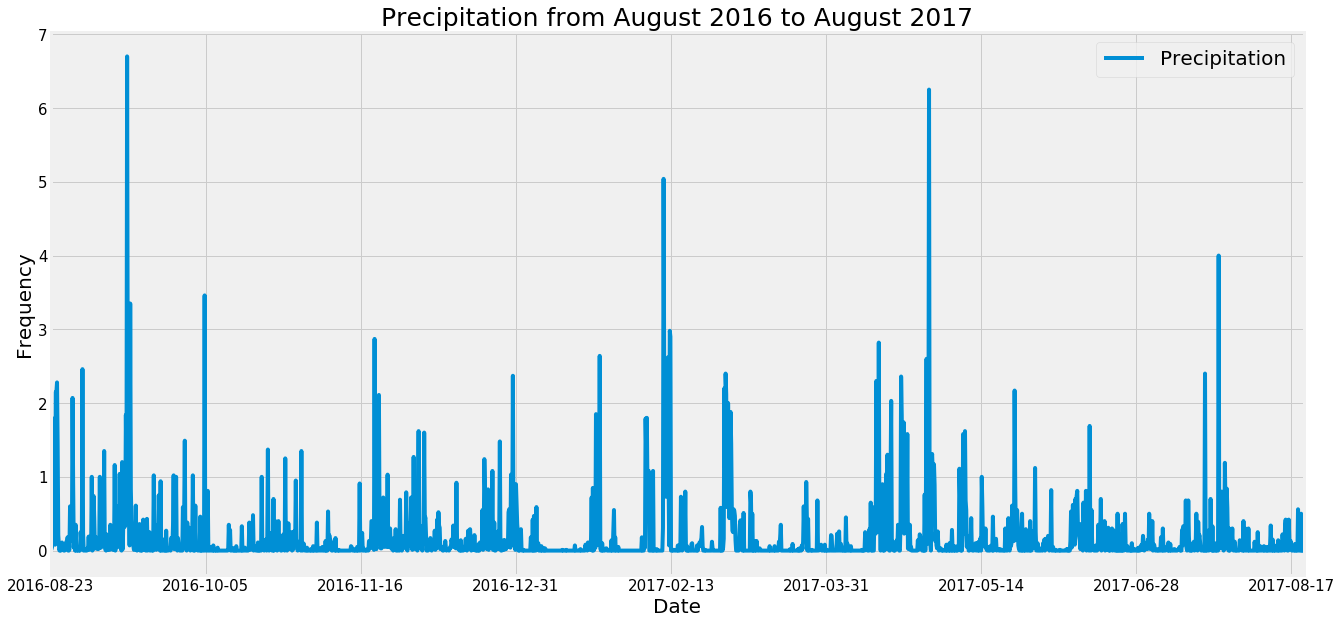

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
m_prec = session.query(Measurement.prcp,Measurement.date).\
    filter(Measurement.date.between('2016-08-23','2017-08-23')).statement

# Perform a query to retrieve the data and precipitation scores

m_df = pd.read_sql(m_prec,session.bind)
m_df = m_df.dropna()

# Save the query results as a Pandas DataFrame and set the index to the date column
m_df = m_df.set_index('date')

m_df

# Sort the dataframe by date
m_sort = m_df.sort_values(by='date',ascending=True)
m_sort.columns = ['Precipitation']

print(m_sort.head())
# Use Pandas Plotting with Matplotlib to plot the data
m_sort.plot(kind="line",figsize=(20,10));

#Format chart
plt.title("Precipitation from August 2016 to August 2017",size=25)
plt.xlabel('Date',size=20)
plt.ylabel('Frequency',size=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.legend(prop={'size':20});



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(m_sort.describe())

       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
s_query = session.query(Measurement.station,Station.name)\
    .filter(Measurement.station==Station.station).statement

station_df = pd.read_sql(s_query,session.bind)
station_df.head()

station_group = station_df.groupby('station')
station_count = station_group.count()

sc_df = pd.DataFrame(station_count).reset_index()
sc_df = sc_df.sort_values(by='name',ascending=False)


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
print(sc_df)

       station  name
6  USC00519281  2772
7  USC00519397  2724
1  USC00513117  2709
8  USC00519523  2669
3  USC00516128  2612
2  USC00514830  2202
0  USC00511918  1979
4  USC00517948  1372
5  USC00518838   511


In [14]:
s = session.query(Measurement.tobs,Station.id)\
    .filter(Measurement.station==Station.station).filter(Station.station=='USC00519281').statement

station_seven = pd.read_sql(s,session.bind)
station_seven.head()

,tobs,id
0,70.0,7
1,62.0,7
2,74.0,7
3,75.0,7
4,74.0,7


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_station = station_seven['tobs'].min()
high_station = station_seven['tobs'].max()
avg_station = station_seven['tobs'].mean()

print(f"Minimum Temperature: {min_station} Maximum Temperature: {high_station} Average Temperature:\
 {avg_station}")


Minimum Temperature: 54.0 Maximum Temperature: 85.0 Average Temperature: 71.66378066378067


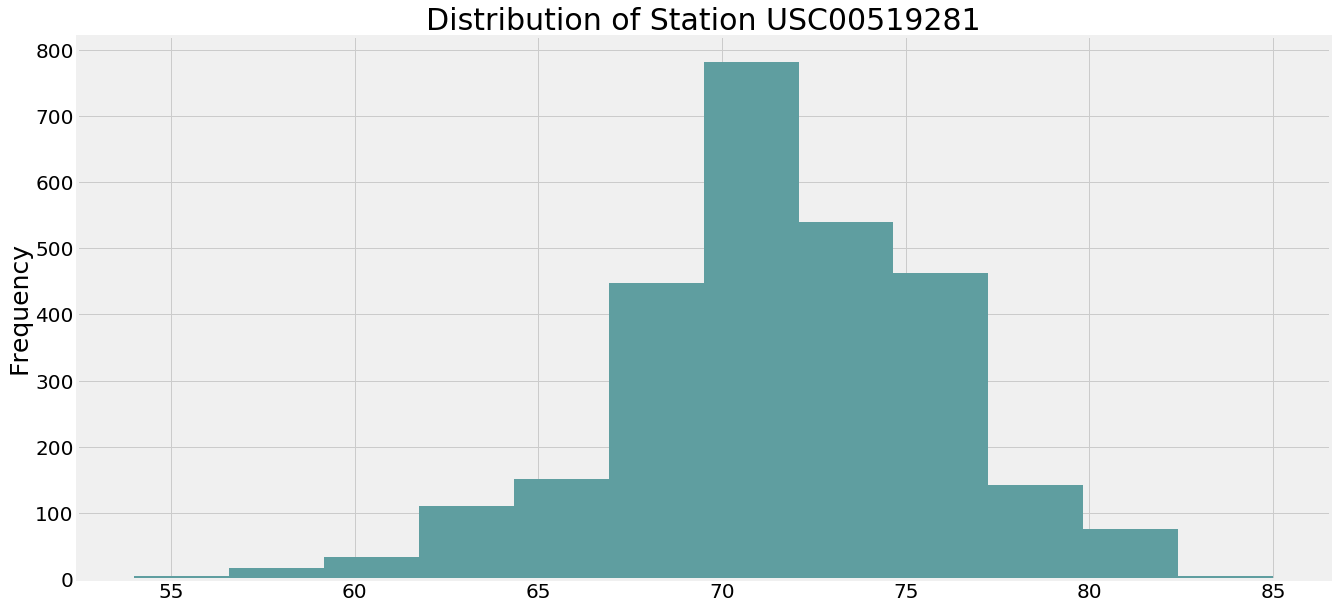

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_seven['tobs'].plot(kind="hist",bins=12,figsize=(20,10), color="cadetblue");
plt.title('Distribution of Station USC00519281', size=30)
plt.ylabel('Frequency',size=25);
plt.yticks(size=20);
plt.xticks(size=20);

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-08-23','2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


   Min Temp  Average Temp  Max Temp
0      58.0     74.590583      87.0


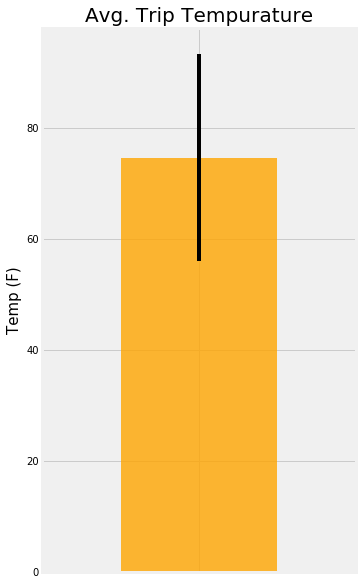

In [74]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ct = session.query(func.min(Measurement.tobs).label('Min Temp'), func.avg(Measurement.tobs).label('Average Temp')\
        , func.max(Measurement.tobs).label('Max Temp')).filter(Measurement.date >= '2016-08-23').filter(Measurement.date <= '2017-08-23').all()
trip_avg = pd.DataFrame(ct)
print(trip_avg)

#Format chart
trip_avg['Average Temp'].plot(kind="bar",width=.5,alpha=0.8, figsize=(5,10), color='orange',yerr=(trip_avg)*.25);
plt.title('Avg. Trip Tempurature', size=20)
plt.ylabel('Temp (F)', size=15)
plt.tick_params(axis='x',labelbottom=False)

In [103]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
s_sum = session.query(Station.station,Measurement.prcp)\
    .filter(Station.station==Measurement.station).statement
s_rainfall = pd.read_sql(s_sum, session.bind)
s_rainfall.dropna()

sum_group = s_rainfall.groupby('station')

station_sum = sum_group.sum()
station_sum = station_sum.sort_values(by='prcp',ascending=False)
station_sum = station_sum.reset_index()

print(station_sum)

       station     prcp
0  USC00516128  1068.09
1  USC00519281   588.64
2  USC00513117   382.62
3  USC00519523   295.68
4  USC00514830   234.49
5  USC00519397   131.62
6  USC00511918    92.68
7  USC00518838    70.87
8  USC00517948    43.44


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


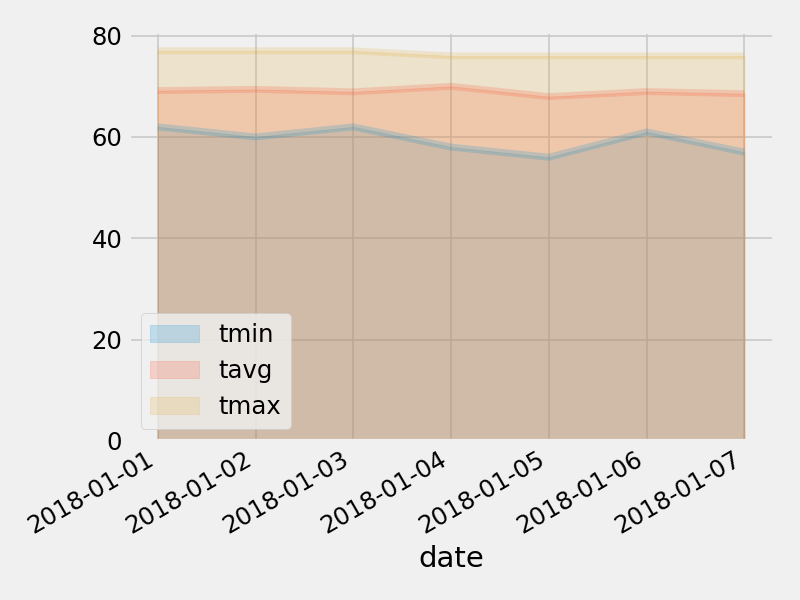

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
